# Convolutional autoencoders and LSTMs for PDE surrogates

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

# For ML construction
from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Reshape
from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model

# For filtering 
from scipy.signal import savgol_filter #1D
from scipy.ndimage import gaussian_filter #nd

### Grab data from Github

In [ ]:
!wget -O train.npy https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/Science_Data/train.npy?raw=true
!wget -O validation.npy https://github.com/argonne-lcf/ATPESC_MachineLearning/blob/master/AE_and_GAN/Science_Data/validation.npy?raw=true

### Load SWE snapshot data into the proper arrays and rescale

In [2]:
swe_data = np.transpose(np.load('train.npy'))
swe_data_v = np.transpose(np.load('validation.npy'))

swe_train_data = np.zeros(shape=(400,64,64,3)) # Channels last
swe_valid_data = np.zeros(shape=(400,64,64,3)) # Channels last

for i in range(np.shape(swe_data)[0]):
    temp_1 = swe_data[i,0:64*64].reshape(64,64)
    temp_2 = swe_data[i,64*64:2*64*64].reshape(64,64)
    temp_3 = swe_data[i,2*64*64:3*64*64].reshape(64,64)
    swe_train_data[i,:,:,0] = np.transpose(temp_1[:,:])
    swe_train_data[i,:,:,1] = np.transpose(temp_2[:,:])
    swe_train_data[i,:,:,2] = np.transpose(temp_3[:,:])
    
for i in range(np.shape(swe_data)[0]):
    temp_1 = swe_data_v[i,0:64*64].reshape(64,64)
    temp_2 = swe_data_v[i,64*64:2*64*64].reshape(64,64)
    temp_3 = swe_data_v[i,2*64*64:3*64*64].reshape(64,64)
    swe_valid_data[i,:,:,0] = np.transpose(temp_1[:,:])
    swe_valid_data[i,:,:,1] = np.transpose(temp_2[:,:])
    swe_valid_data[i,:,:,2] = np.transpose(temp_3[:,:])

# Scale between 0 and 1
for j in range(3):
    swe_train_data[:,:,:,j] = (swe_train_data[:,:,:,j] - np.min(swe_train_data[:,:,:,0]))/(np.max(swe_train_data[:,:,:,0])-np.min(swe_train_data[:,:,:,0]))
    swe_valid_data[:,:,:,j] = (swe_valid_data[:,:,:,j] - np.min(swe_valid_data[:,:,:,0]))/(np.max(swe_valid_data[:,:,:,0])-np.min(swe_valid_data[:,:,:,0]))

### Visualize the data set

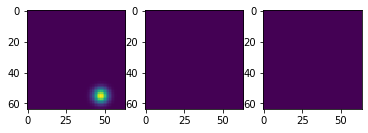

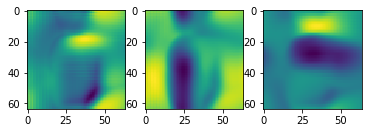

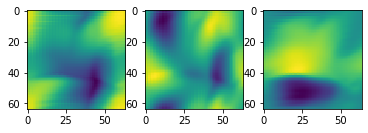

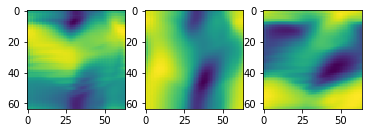

In [3]:
# Visualize multiple time instances
for time in range(0,400,100):
    fig, ax = plt.subplots(nrows=1,ncols=3)
    ax[0].imshow(swe_train_data[time,:,:,0])
    ax[1].imshow(swe_train_data[time,:,:,1])
    ax[2].imshow(swe_train_data[time,:,:,2])
    plt.show()

### Do a shift of the training data for one-step prediction in the future

In [4]:
# Do some shifting to allow for LSTM pipeline
swe_evolve_data = swe_train_data[1:]
swe_train_data = swe_train_data[:-1]

### ML Presets and Custom Functions

In [5]:
mode = 'train'
lrate = 0.001

def mean_absolute_error(y_pred,y_true):
    return K.mean(K.abs(y_true-y_pred))

def max_absolute_error(y_pred,y_true):
    return K.max(K.abs(y_true-y_pred))

### Autoencoder + LSTM pipeline

In [6]:
## Define recursive model architecture
weights_filepath = 'Model_weights.h5'

# Encoder
encoder_inputs = Input(shape=(64,64,3),name='Field')

x = Conv2D(30,kernel_size=(3,3),activation='relu',padding='same')(encoder_inputs)
enc_l2 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')(enc_l2)
enc_l3 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(10,kernel_size=(3,3),activation='relu',padding='same')(enc_l3)
enc_l4 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(15,kernel_size=(3,3),activation='relu',padding='same')(enc_l4)
enc_l5 = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

x = Conv2D(1,kernel_size=(3,3),activation=None,padding='same')(enc_l5)
encoded = MaxPooling2D(pool_size=(2, 2),padding='same')(x)

# LSTM starts
x = Reshape((1,4))(encoded)
x = LSTM(20,input_shape=(1,4,),return_sequences=True)(x)
# x = LSTM(20,input_shape=(1,4,),return_sequences=True)(x)
x = Dense(4,activation=None)(x)
lstm_outputs = Reshape((2,2,1))(x)
  
# Decoder architecture
dec_layer_1 = Conv2D(1,kernel_size=(3,3),activation='relu',padding='same')
dec_layer_2 = Conv2D(5,kernel_size=(3,3),activation='relu',padding='same')
dec_layer_3 = Conv2D(10,kernel_size=(3,3),activation='relu',padding='same')
dec_layer_4 = Conv2D(20,kernel_size=(3,3),activation='relu',padding='same')
dec_layer_5 = Conv2D(30,kernel_size=(3,3),activation='relu',padding='same')
dec_layer_6 = Conv2D(3,kernel_size=(3,3),activation=None,padding='same')

# Decoder starts using LSTM pipeline
x = dec_layer_1(lstm_outputs)
dec_l1 = UpSampling2D(size=(2, 2))(x)

x = dec_layer_2(dec_l1)
dec_l2 = UpSampling2D(size=(2, 2))(x)

x = dec_layer_3(dec_l2)
dec_l3 = UpSampling2D(size=(2, 2))(x)

x = dec_layer_4(dec_l3)
dec_l4 = UpSampling2D(size=(2, 2))(x)

x = dec_layer_5(dec_l4)
dec_l5 = UpSampling2D(size=(2, 2))(x)

ae_lstm_decoded = dec_layer_6(dec_l5)
    
# Decoder starts using pure autoencoder pipeline
x = dec_layer_1(encoded)
dec_l1 = UpSampling2D(size=(2, 2))(x)

x = dec_layer_2(dec_l1)
dec_l2 = UpSampling2D(size=(2, 2))(x)

x = dec_layer_3(dec_l2)
dec_l3 = UpSampling2D(size=(2, 2))(x)

x = dec_layer_4(dec_l3)
dec_l4 = UpSampling2D(size=(2, 2))(x)

x = dec_layer_5(dec_l4)
dec_l5 = UpSampling2D(size=(2, 2))(x)

ae_decoded = dec_layer_6(dec_l5)

model = Model(inputs=encoder_inputs,outputs=[ae_decoded,ae_lstm_decoded],name='CAE')
   
# design network
my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint]

# fit network
model.compile(optimizer=my_adam,loss='mean_squared_error',metrics=[mean_absolute_error,max_absolute_error])    
model.summary()

num_epochs = 500
batch_size = 4

if mode == 'train':
    train_history = model.fit(x=swe_train_data, 
                              y=[swe_train_data,swe_evolve_data], 
                              epochs=num_epochs, 
                              batch_size=batch_size, 
                              callbacks=callbacks_list,
                              validation_split = 0.1)

Model: "CAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Field (InputLayer)              [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 30)   840         Field[0][0]                      
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 30)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 20)   5420        max_pooling2d[0][0]              
________________________________________________________________________________________________

KeyboardInterrupt: 

### Check accuracy of autoencoder

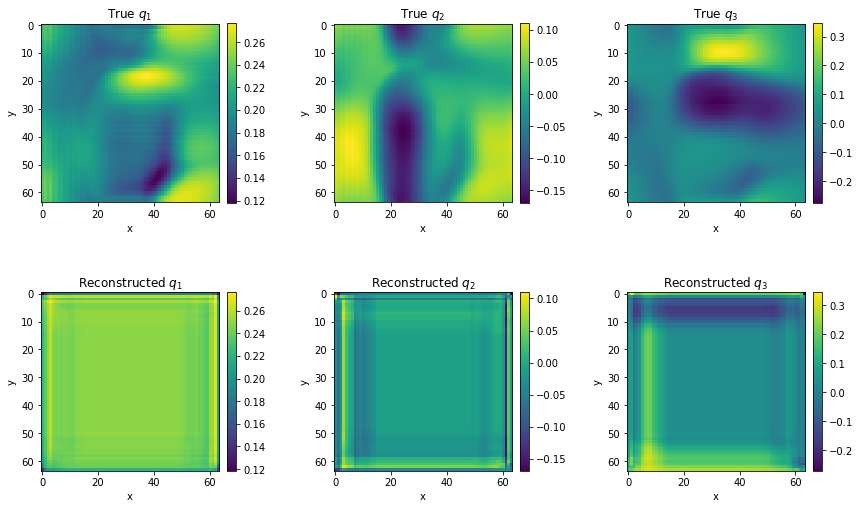

In [7]:
time = 100

model.load_weights(weights_filepath)
recoded_1 = model.predict(swe_train_data[time:time+1,:,:,:])[0]

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(14,12))

cs1 = ax[0,0].imshow(swe_train_data[time,:,:,0],label='input')
ax[1,0].imshow(recoded_1[0,:,:,0],label='decoded')

cs2 = ax[0,1].imshow(swe_train_data[time,:,:,1],label='input')
ax[1,1].imshow(recoded_1[0,:,:,1],label='decoded')

cs3 = ax[0,2].imshow(swe_train_data[time,:,:,2],label='input')
ax[1,2].imshow(recoded_1[0,:,:,2],label='decoded')

for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel('x')
        ax[i,j].set_ylabel('y')
        
fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(cs1,ax=ax[1,0],fraction=0.046, pad=0.04)

fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,1],fraction=0.046, pad=0.04)

fig.colorbar(cs3,ax=ax[0,2],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[1,2],fraction=0.046, pad=0.04)


ax[0,0].set_title(r'True $q_1$')
ax[0,1].set_title(r'True $q_2$')
ax[0,2].set_title(r'True $q_3$')

ax[1,0].set_title(r'Reconstructed $q_1$')
ax[1,1].set_title(r'Reconstructed $q_2$')
ax[1,2].set_title(r'Reconstructed $q_3$')

plt.subplots_adjust(wspace=0.5,hspace=-0.3)
plt.show()

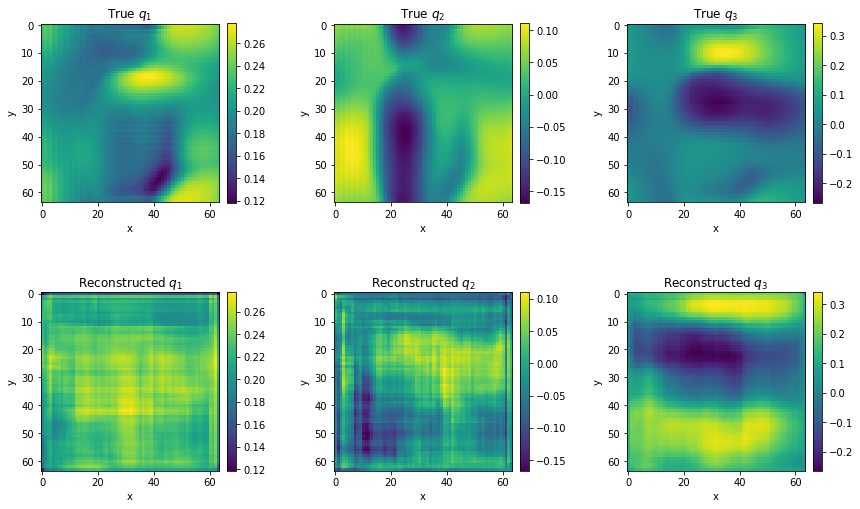

In [8]:
time = 100
recoded_1 = model.predict(swe_train_data[time:time+1,:,:,:])[1]

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(14,12))

cs1 = ax[0,0].imshow(swe_evolve_data[time,:,:,0],label='input')
ax[1,0].imshow(recoded_1[0,:,:,0],label='decoded')

cs2 = ax[0,1].imshow(swe_evolve_data[time,:,:,1],label='input')
ax[1,1].imshow(recoded_1[0,:,:,1],label='decoded')

cs3 = ax[0,2].imshow(swe_evolve_data[time,:,:,2],label='input')
ax[1,2].imshow(recoded_1[0,:,:,2],label='decoded')

for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel('x')
        ax[i,j].set_ylabel('y')
        
fig.colorbar(cs1,ax=ax[0,0],fraction=0.046, pad=0.04)
fig.colorbar(cs1,ax=ax[1,0],fraction=0.046, pad=0.04)

fig.colorbar(cs2,ax=ax[0,1],fraction=0.046, pad=0.04)
fig.colorbar(cs2,ax=ax[1,1],fraction=0.046, pad=0.04)

fig.colorbar(cs3,ax=ax[0,2],fraction=0.046, pad=0.04)
fig.colorbar(cs3,ax=ax[1,2],fraction=0.046, pad=0.04)


ax[0,0].set_title(r'True $q_1$')
ax[0,1].set_title(r'True $q_2$')
ax[0,2].set_title(r'True $q_3$')

ax[1,0].set_title(r'Reconstructed $q_1$')
ax[1,1].set_title(r'Reconstructed $q_2$')
ax[1,2].set_title(r'Reconstructed $q_3$')

plt.subplots_adjust(wspace=0.5,hspace=-0.3)
plt.show()

### Check latent representation of the CAE

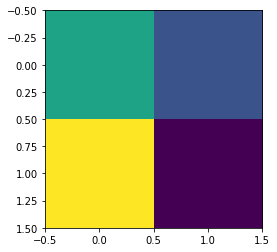

In [9]:
time = 100
get_latent_representation = K.function([model.layers[0].input],
                                  [model.layers[10].output]) # Layer number 10 is the MaxPooling2D before entry to LSTM
layer_output = get_latent_representation([swe_train_data])[0]
plt.imshow(layer_output[time,:,:,0])

### Check its variation in time

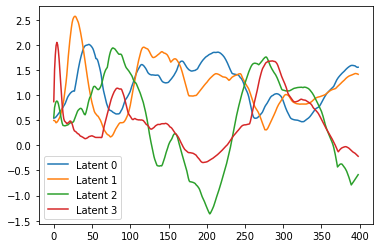

In [10]:
plt.figure()
plt.plot(layer_output[:,0,0,0],label='Latent 0')
plt.plot(layer_output[:,0,1,0],label='Latent 1')
plt.plot(layer_output[:,1,0,0],label='Latent 2')
plt.plot(layer_output[:,1,1,0],label='Latent 3')
plt.legend()
plt.show()